# import and load data

In [1]:
from my_imports import *
import stanTools
from sklearn import mixture
from collections import Counter
import copy

# to use  my own stylimport matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import pearsonr

mpl.rcParams.update(mpl.rcParamsDefault)

avb_cols = {'pur':'#5B49B6', 
            'blu':'#52A4D9', 
            'tur':'#59C09D',
            'tea':'#B3EBAD',
            'yel': '#C3D64C',
            'gra':'#9B9B9D'}
avb_contrast_cols = {
    'p': '#C17EFF',
    'g': '#75C26A'
}
plt.style.use('/Users/davidding/PycharmProjects/pareSingleLibrary2/codebase/src/paper_style1.mplstyle')



plot_out= '/Users/davidding/PycharmProjects/pareSingleLibrary2/codebase/pairedEnd/x51/2009_out/processing/'


/Users/davidding/anaconda3/envs/tf_env/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
/Users/davidding/anaconda3/envs/tf_env/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/davidding/anaconda3/envs/tf_env/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# fin_tuples
ex51_high, ex51_low, ex47_high, ex47_low = lct.fetch_all_filepairs(
    count_dir_ex47='./df/tc/ex47/', count_dir_ex51='./df/tc/ex51/')

at_to_fin_tuple_all = {}

for k,v in ex51_low.items():
    if k not in ['wtAT']:
        at_to_fin_tuple_all[k] = v
for k,v in ex47_low.items():
    if k not in ['wtAT']:
        at_to_fin_tuple_all[k] = v

len(at_to_fin_tuple_all)

15
15
30


37

In [3]:
# get all the log read ratios for all the different antitoxin mutant backgrounds
def get_scaled_df_m_aa_mean(fin_tuple, pseudocount=1):
    '''from replicate csv file of read counts to scaled amino acid mean log read ratio'''
    data_all, data_r1, data_r2, aa_dic, df_m, df_syn = stanTools.get_stan_data(fin_tuple[0], fin_tuple[1])

    #print(df_m.columns)
    df_m = df_m.rename(columns={
        'raw_count_r1'     : 'c_pre_m1',
        'raw_count_post_r1': 'c_aft_m1',
        'raw_count_r2'     : 'c_pre_m2',
        'raw_count_post_r2': 'c_aft_m2'
    })

    # with pseudocount =1
    df_m = stanTools.add_ratios_lrr_df_m(df_m, pseudocount=pseudocount, correct_seq_depth=True)
    df_m_aa_mean = df_m.groupby('mutkey').mean()
    
    return df_m_aa_mean


importlib.reload(stanTools)
pseudocount=1
df_all = pd.DataFrame(columns = ['mutkey', 'codonkey', 'c_pre_m1', 'c_aft_m1', 'c_pre_m2', 'c_aft_m2',
       'g_idx', 'ratio1', 'ratio2', 'lrr1', 'lrr2'])
for at,fin_tuple in at_to_fin_tuple_all.items():
    df_m_aa_mean = get_scaled_df_m_aa_mean(fin_tuple)

    df_all = pd.concat([df_all,df_m_aa_mean])
    
    

/Users/davidding/PycharmProjects/pareSingleLibrary2/codebase/src/stanTools.py:993: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep1['raw_count_post_r1'] = df_rep1['raw_count_post_r1'].fillna(0)
/Users/davidding/PycharmProjects/pareSingleLibrary2/codebase/src/stanTools.py:994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep2['raw_count_post_r2'] = df_rep2['raw_count_post_r2'].fillna(0)
/Users/davidding/PycharmProjects/pareSingleLibrary2/codebase/src/stanTools.py:403: SettingWithCopyWarning: 
A valu

In [4]:
# adding the no antitoxin observations
count_dir_ex47='./df/tc/ex47/'
count_dir_ex51='./df/tc/ex51/'
conc_to_fs = {
    # these 2 concentrations already done
    #1.2e-4 : (count_dir_ex47 + '178_mcsAT_tc.csv', count_dir_ex47+'179_mcsAT_tc.csv'),
    #8e-4 : (count_dir_ex47 + '180_mcsAT_tc.csv', count_dir_ex47+ '181_mcsAT_tc.csv'),
    5.3e-3: (count_dir_ex47 + '182_mcsAT_tc.csv', count_dir_ex47+ '183_mcsAT_tc.csv'),
    0.2: (count_dir_ex47 + '184_mcsAT_tc.csv', count_dir_ex47+ '185_mcsAT_tc.csv'),
    2e-5: (count_dir_ex51 + '190_m_tc.csv', count_dir_ex51 + '191_m_tc.csv'),
    4e-5: (count_dir_ex51 + '188_m_tc.csv', count_dir_ex51 + '189_m_tc.csv'),
    8e-5: (count_dir_ex51 + '186_m_tc.csv', count_dir_ex51 + '187_m_tc.csv')
}

for conc,fin_tuple in conc_to_fs.items():
    df_m_aa_mean = get_scaled_df_m_aa_mean(fin_tuple)

    
    df_all = pd.concat([df_all,df_m_aa_mean])
    
    

In [5]:
# add toxin single mutants with wt AT, and the antitoxin single mutants + wt Toxin.
count_dir_ex47='./df/tc/ex47/'
count_dir_ex51='./df/tc/ex51/'

wt_at_to_fs = {
    'wt1': (count_dir_ex51 + '178_wtAT_tc.csv', count_dir_ex51 + '179_wtAT_tc.csv'),
    'wt2': (count_dir_ex51 + '182_wtAT_tc.csv', count_dir_ex51+'183_wtAT_tc.csv')
}
fin_tuple = wt_at_to_fs['wt1']
df_m_aa_mean = get_scaled_df_m_aa_mean(fin_tuple)

df_all = pd.concat([df_all,df_m_aa_mean])
################################### AT singles
at_df_path = './df/tc/ex39/'
fin_tuple = (at_df_path + '41_tc_nov2019.csv', at_df_path + '42_tc_nov2019.csv')

df_m_aa_mean_at = get_scaled_df_m_aa_mean(fin_tuple)

df_all = pd.concat([df_all,df_m_aa_mean_at])


# plotting

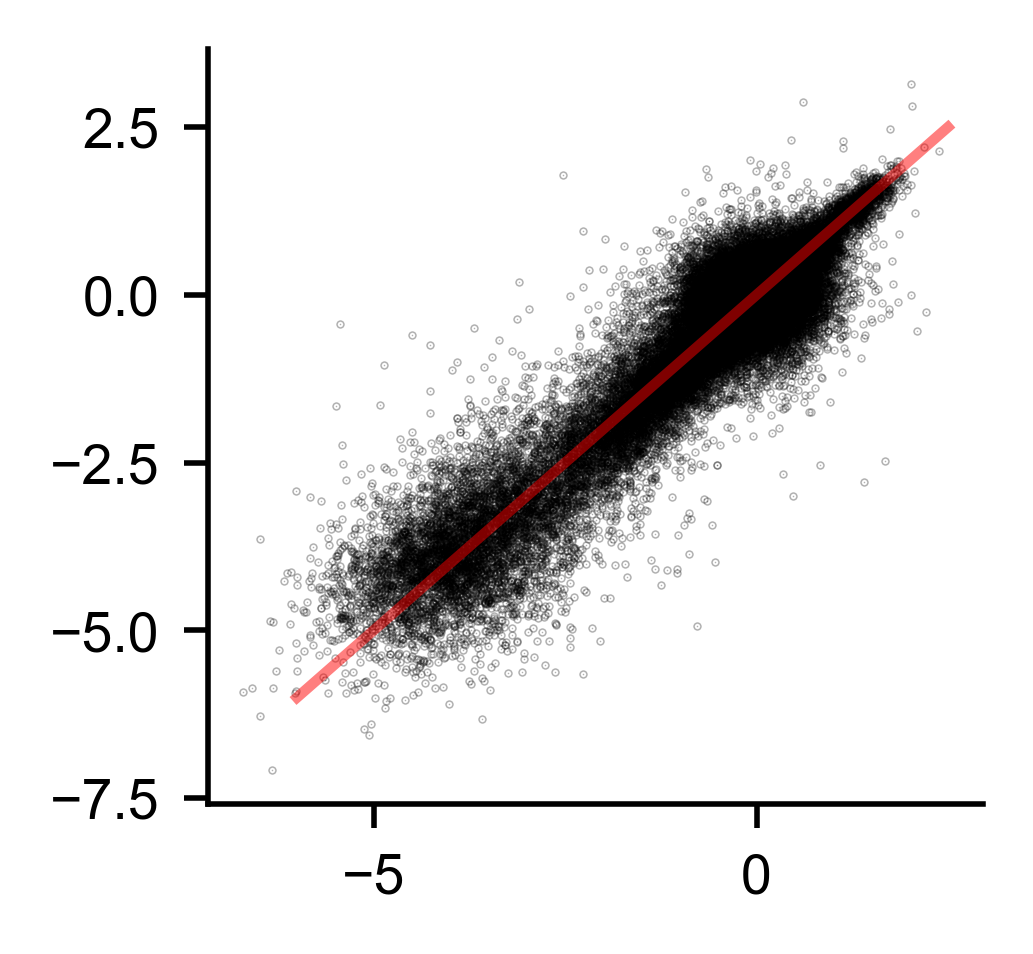

In [8]:
### # all doubles and singles
plt.figure(figsize=(2,2), dpi=500)
plt.scatter(df_all.lrr1/np.log(2), df_all.lrr2 / np.log(2), s=0.05, alpha=0.3, color='black')
plt.plot([-6,2.5], [-6, 2.5], color='red', alpha=0.5)
#plt.title(' pearsonr: {:.2f}'.format(pearsonr(df_all.lrr1, df_all.lrr2)[0]))
#plt.xlabel('log read ratio biological replicate 1')
#plt.ylabel('log read ratio biological replicate 2')
pearsonr(df_all.lrr1, df_all.lrr2)
plt.xticks(size=8)
plt.yticks(size=8)

plt.savefig(plot_out + 'lrr_reproduce_all_doubles_mcs.pdf', format='pdf')
plt.savefig(plot_out + 'lrr_reproduce_all_doubles_mcs.jpeg', format='jpeg', quality=100)